In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import illustris_python as il

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

def get_dataframes():
    df_03 = pd.read_hdf('var_esc.h5', '0.3')
    update_df(df_03)
    df_05 = pd.read_hdf('var_esc.h5', '0.5')
    update_df(df_05)
    df_07 = pd.read_hdf('var_esc.h5', '0.7')
    update_df(df_07)
    df_10 = pd.read_hdf('var_esc.h5', '1.0')
    update_df(df_10)
    df_no_dust = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
    update_df(df_no_dust)
    df_arr = [df_no_dust, df_03, df_05, df_07, df_10]
    return df_arr

In [4]:
def build_df_comparison(df_arr):
    ID = []
    z = []
    HaloMass = []
    Metallicity = []
    FractionStars = []
    FractionGas = []
    FractionDust = []
    Q0 = []
    aStar = []
    HaloRadii = []
    Q0_HaloMass = []
    R_v_3_HaloMass = []
    StarMass = []
    f_esc01 = []
    f_esc03 = []
    f_esc05 = []
    f_esc07 = []
    f_esc10 = []

    for _, element in df_arr[1].iterrows():
        halo_exist = []
        for df in df_arr:
            exist_in_df = len(df[(df.z==element.z)&(df.ID==element.ID)])
            halo_exist.append(exist_in_df)
        halo_exist = np.array(halo_exist)

        if ((halo_exist==1).all()):
            ID.append(element.ID)
            z.append(element.z)
            HaloMass.append(element.HaloMass)
            Metallicity.append(element.Metallicity)
            FractionStars.append(element.FractionStars)
            FractionGas.append(element.FractionGas)
            FractionDust.append(element.FractionDust)
            Q0.append(element.Q0)
            aStar.append(element.aStar)
            HaloRadii.append(element.HaloRadii)
            Q0_HaloMass.append(element['Q0/HaloMass'])
            R_v_3_HaloMass.append(element['R_v^3/HaloMass'])
            StarMass.append(element.StarMass)

            f_esc01.append(float(df_arr[0][(df_arr[0].z==element.z)&(df_arr[0].ID==element.ID)].f_esc))
            f_esc03.append(float(df_arr[1][(df_arr[1].z==element.z)&(df_arr[1].ID==element.ID)].f_esc))
            f_esc05.append(float(df_arr[2][(df_arr[2].z==element.z)&(df_arr[2].ID==element.ID)].f_esc))
            f_esc07.append(float(df_arr[3][(df_arr[3].z==element.z)&(df_arr[3].ID==element.ID)].f_esc))
            f_esc10.append(float(df_arr[4][(df_arr[4].z==element.z)&(df_arr[4].ID==element.ID)].f_esc))
    df_comparison = pd.DataFrame({'ID':ID, 'z':z, 'HaloMass':HaloMass, 'Metallicity':Metallicity, 'FractionStars':FractionStars, 'FractionGas':FractionGas, 'FractionDust':FractionDust, 
                                  'Q0':Q0, 'aStar':aStar, 'HaloRadii':HaloRadii,'Q0/HaloMass':Q0_HaloMass, 'R_v^3/HaloMass':R_v_3_HaloMass, 'StarMass':StarMass,
                                  'f_esc01':f_esc01, 'f_esc03':f_esc03, 'f_esc05':f_esc05, 'f_esc07':f_esc07, 'f_esc10':f_esc10})
    return df_comparison

In [5]:
df_array = get_dataframes()

In [6]:
df = build_df_comparison(df_array)

In [17]:
def plot_scatter(df, prop='StarMass', bins=20, mode='median', abs_esc=False, save = False):
    labelsize = 70
    legendsize = 45
    ticksize = 55
    linewidth = 5
    errorwidth = 3
    capsize = 10
    major_tick_length = 20
    major_tick_width = 4
    minor_tick_length = 8
    minor_tick_width = 2
    axes_width = 4
    figheight = 20
    figwidth = 20
    lower_ylim = 0.5e-3
    upper_ylim = 1.
    
    if prop == 'HaloMass':
        halo_prop = 'HaloMass'
        x_label = 'Halo Mass [$10^{10}M_{\mathrm{sun}}$]'
    elif prop == 'StarMass':    
        halo_prop = 'StarMass'
        x_label = 'Stellar Mass [$10^{6}M_{\mathrm{sun}}$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
    
    if abs_esc:
        loc_escs = np.array([0.1,0.3,0.5,0.7,1.0])
    else:
        loc_escs = np.ones(5)
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    f_escs = ['f_esc01', 'f_esc03', 'f_esc05', 'f_esc07', 'f_esc10']
    labels = ['0.1', '0.3', '0.5', '0.7', '1.0']
    
    fig, ax1 = plt.subplots()
    for j, esc in enumerate(f_escs):     
        means = []
        error = []
        centers = []
        variance = []
        for i in range(len(edges)-1):
            sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][esc]*loc_escs[j]
            centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))

            if mode == 'median':
                means.append(sub_fesc.median())
            elif mode == 'mean':
                means.append(sub_fesc.mean())
            error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
            variance.append(sub_fesc.var())
            
        centers = np.array(centers)
        ax1.errorbar(np.log10(centers*1e6), means, yerr=error, linewidth=linewidth, elinewidth=errorwidth, capsize=capsize, label='$f_\mathrm{esc,loc}=$'+labels[j])
    #ax1.set_xscale('log')
    ax1.set_yscale('symlog', linthreshy=1e-4)
    ax1.set_ylim(lower_ylim,upper_ylim)
    ax1.set_ylabel(r'$ \langle f_\mathrm{esc} \rangle $', size=labelsize)
    if prop== 'StarMass':
        ax1.set_xlabel('$M_\mathrm{star}[\log(M_\mathrm{sun})]$', size=labelsize)
    elif prop == 'HaloMass':
        ax1.set_xlabel('$M_\mathrm{halo}[\log(M_\mathrm{sun})]$', size=labelsize)
    ax1.legend(fontsize=legendsize)
    
    #plt.gca().xaxis.set_major_locator(plt.MultipleLocator(8))

    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(100))
    plt.tick_params(length=major_tick_length, width=major_tick_width)
    plt.tick_params(length=minor_tick_length, width=minor_tick_width, which='minor')
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    plt.rcParams["figure.figsize"] = (figwidth,figheight)
    if save:
        if abs_esc:
            attach = '_abs'
        else:
            attach = ''
        plt.savefig(f'/u/ivkos/analysis/plots/fesc_fescloc{attach}.pdf', bbox_inches = 'tight')
    plt.show();

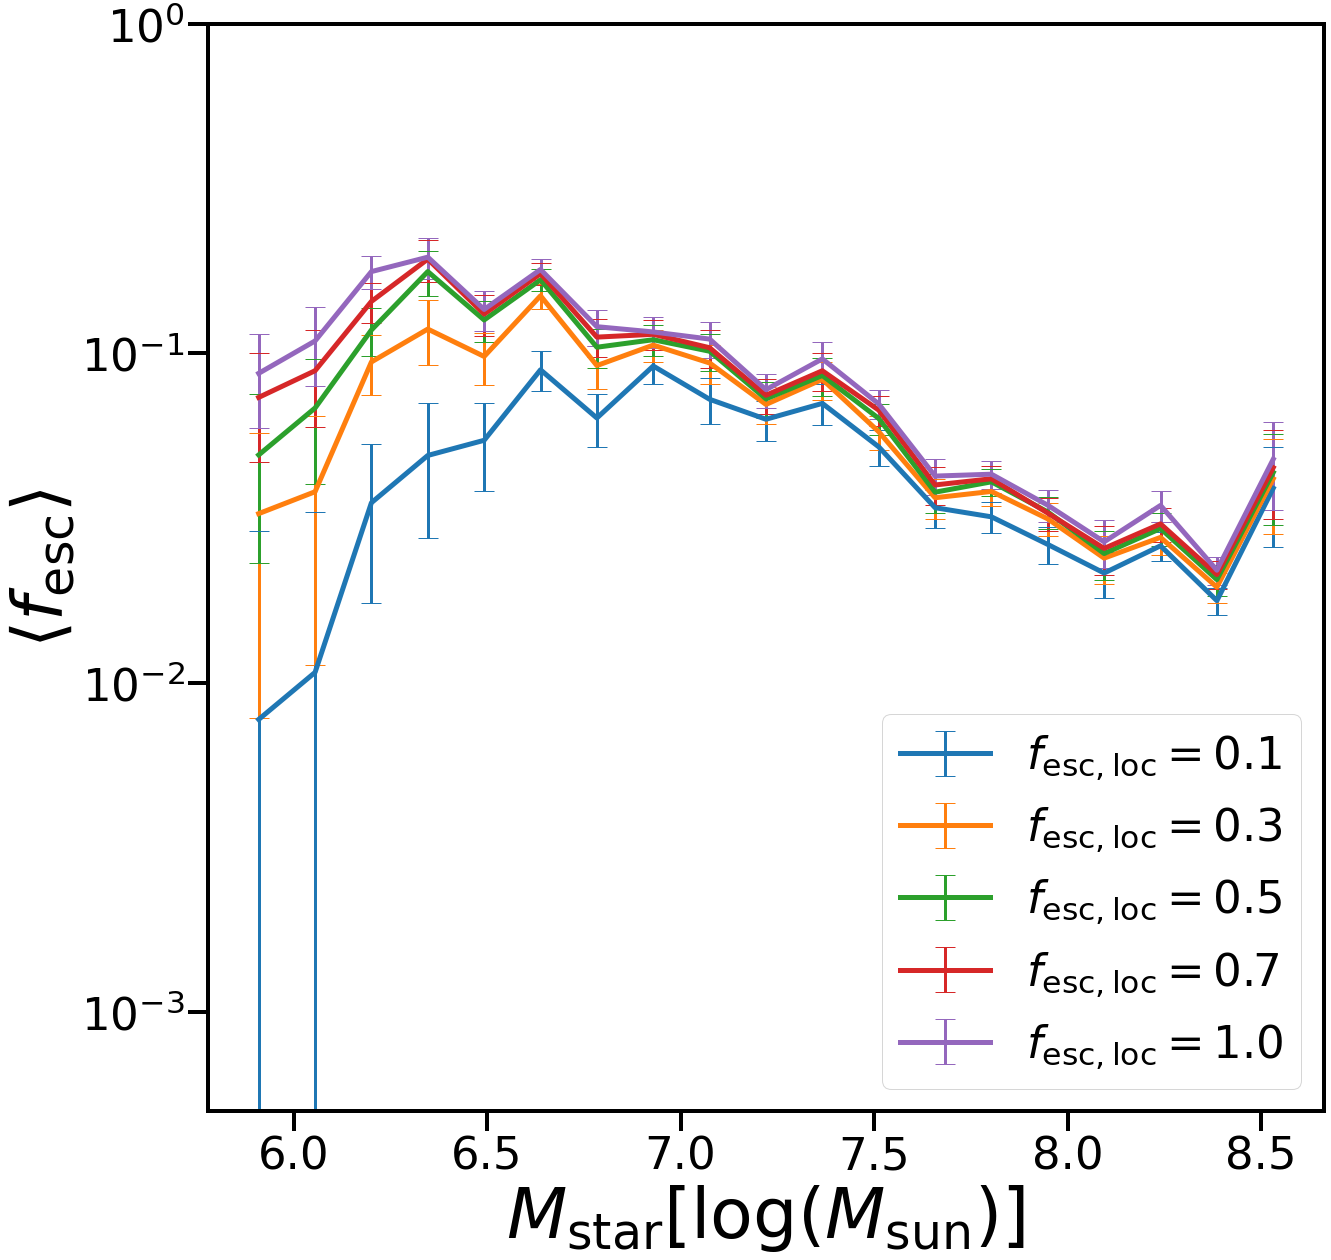

In [18]:
plot_scatter(df, abs_esc=False, save=True)

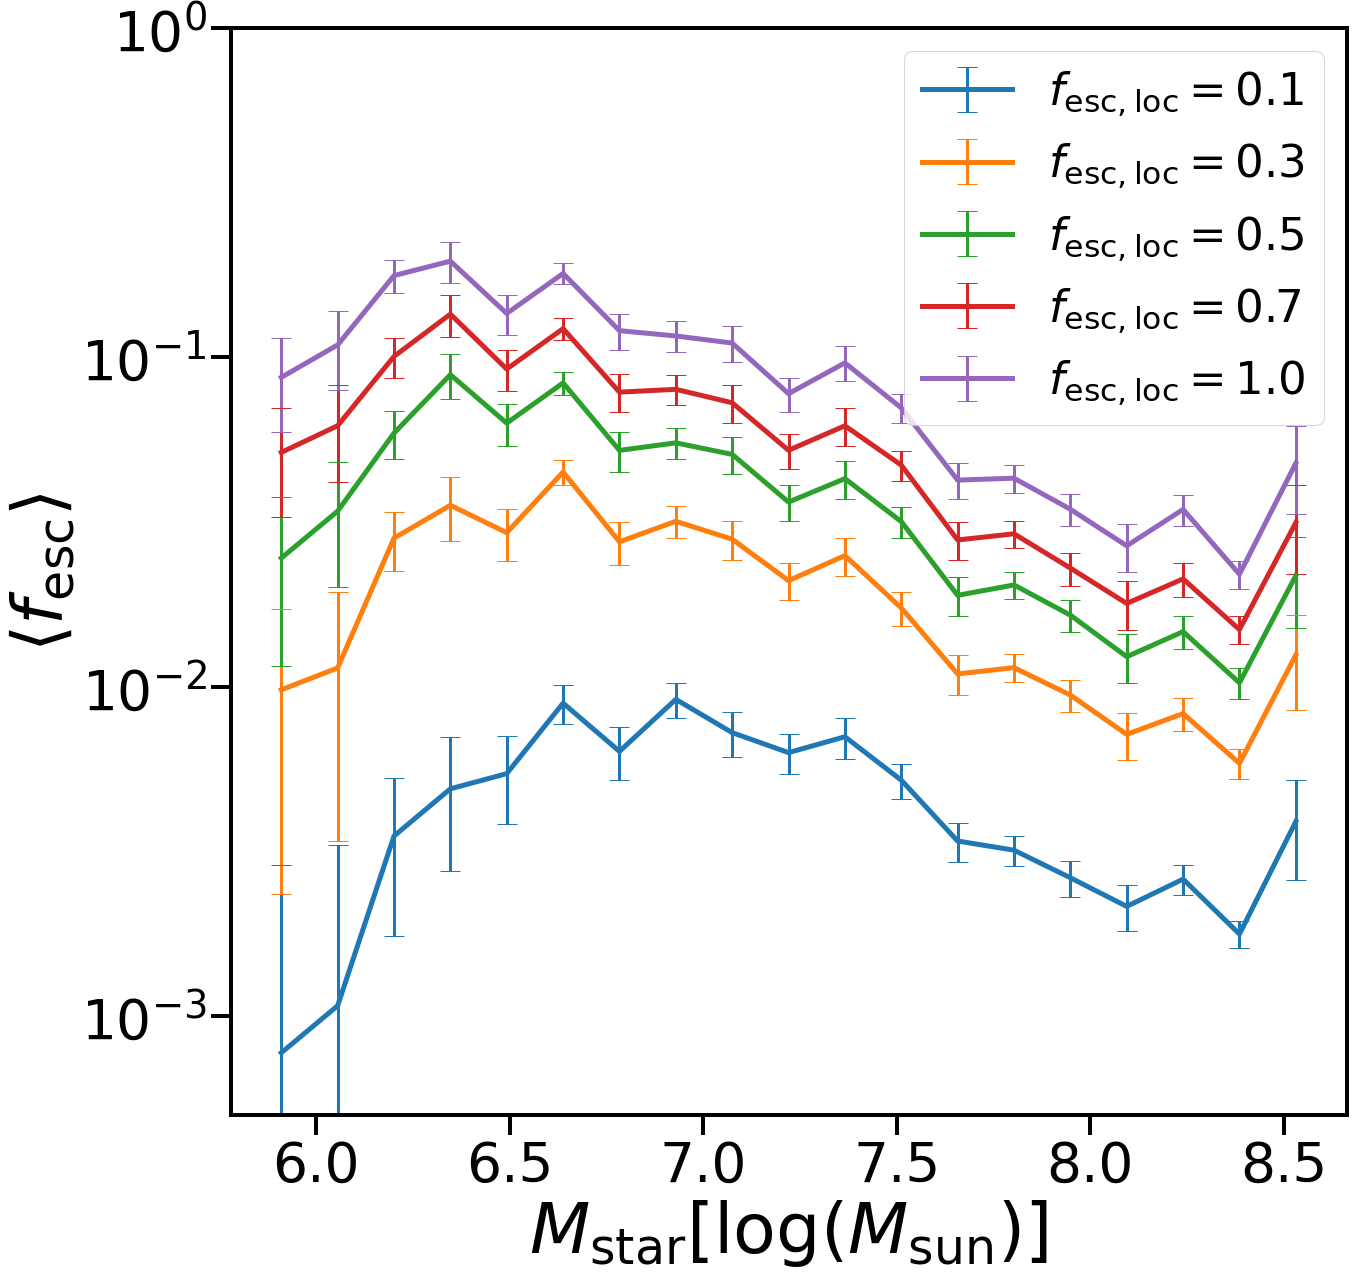

In [19]:
plot_scatter(df, abs_esc=True, save=True)

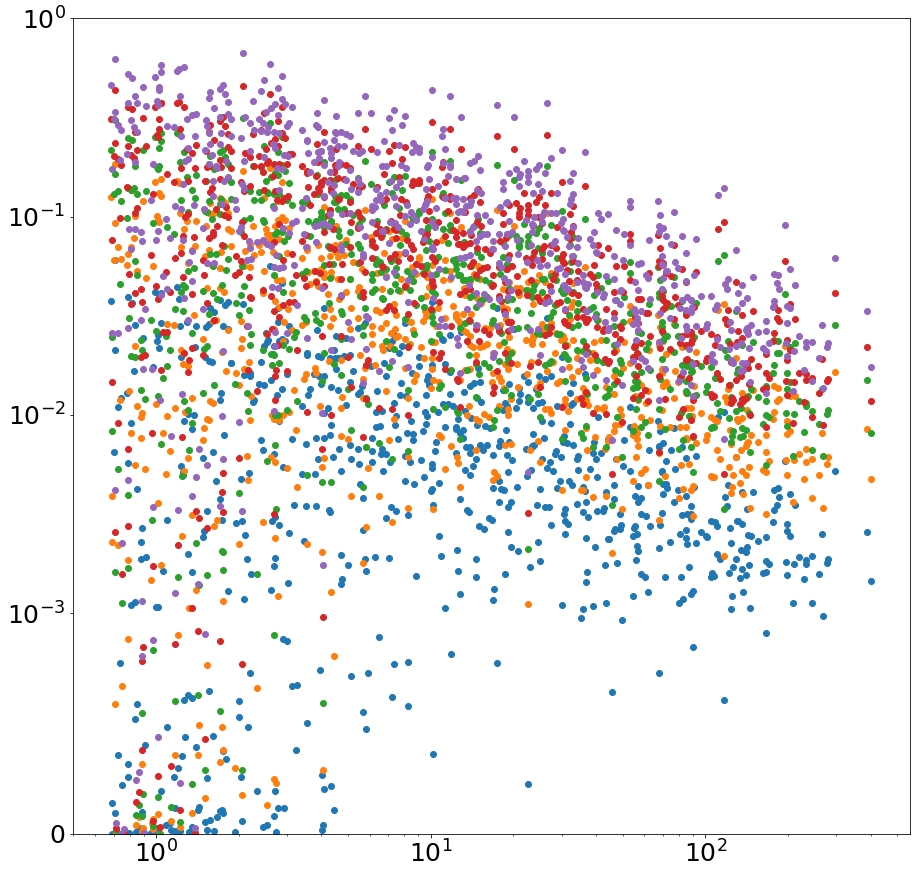

In [87]:
plt.scatter(df.StarMass, df.f_esc01*0.1)
plt.scatter(df.StarMass, df.f_esc03*0.3)
plt.scatter(df.StarMass, df.f_esc05*0.5)
plt.scatter(df.StarMass, df.f_esc07*0.7)
plt.scatter(df.StarMass, df.f_esc10)
plt.yscale('symlog', linthreshy=1e-3)
plt.xscale('log')
plt.ylim(0.0,1.0)
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rcParams["figure.figsize"] = (15,15);